In [1]:
import math
import random
import functools

import numpy as np
import cv2 as cv

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

In [2]:
robotSize = np.array([0.23, 0.19]) # Length x Width
robotCenter = np.array([0.0625/2, 0.19/2])

robotBounds = np.stack([-robotCenter, robotSize-robotCenter])

In [3]:
robotBounds

array([[-0.03125, -0.095  ],
       [ 0.19875,  0.095  ]])

In [4]:
def grayToRGB(src):
    return np.stack([src.copy(), src.copy(), src.copy()], -1)

In [5]:
# unit in cm
obstacle = np.array([
    [160, 50],
    [120, 120],
    [50, 40],
    [20, 160],
    [70, 80]
])

#obstacle = np.array([
#    [80,60]
#])

obsSize = np.array([10, 10]) + np.array([20, 20]) # Size + Inflation

mapScale = 3
mapRange = (200, 200)

mapImg = np.zeros([r * mapScale for r in mapRange], np.uint8)
for i in range(len(obstacle)):
    print(f"{np.floor(mapScale * (obstacle[i] - obsSize/2))}, {np.floor(mapScale * (obstacle[i] + obsSize/2))}")
    mapImg = cv.rectangle(mapImg, tuple(np.floor(mapScale * (obstacle[i] - obsSize/2)).astype(np.int32)), tuple(np.floor(mapScale * (obstacle[i] + obsSize/2)).astype(np.int32)), 255, -1)
start = tuple([ mapScale *  x for x in (20, 20) ])
goal = tuple([ mapScale *  x for x in (110, 90) ])

mapImg = grayToRGB(mapImg)

[435. 105.], [525. 195.]
[315. 315.], [405. 405.]
[105.  75.], [195. 165.]
[ 15. 435.], [105. 525.]
[165. 195.], [255. 285.]


<IPython.core.display.Javascript object>


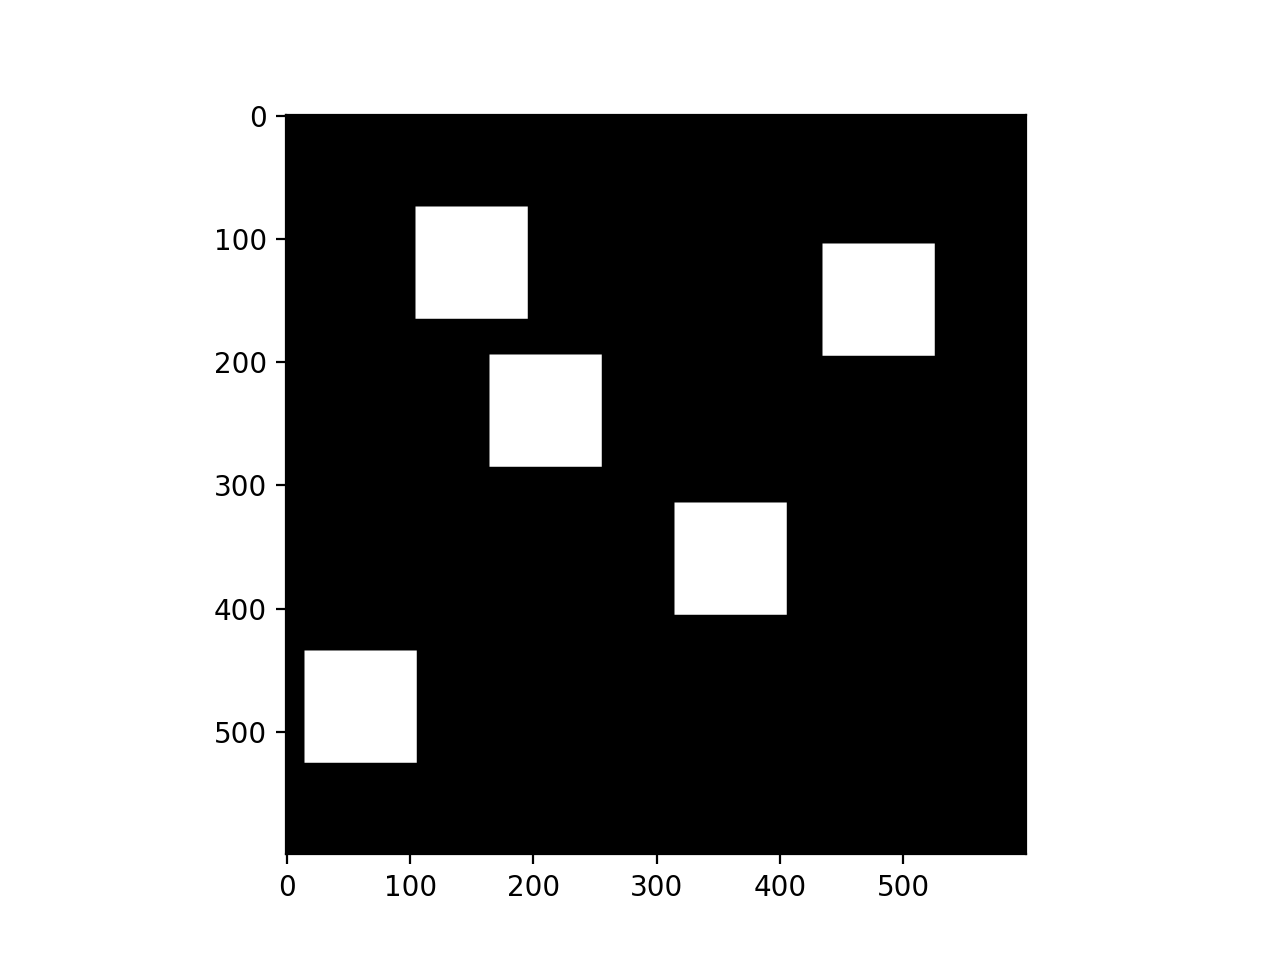

In [6]:
fig1 = plt.figure()
plt.imshow(mapImg)

In [8]:
mapImgG = cv.cvtColor(mapImg, cv.COLOR_RGB2GRAY)
f, mapImgB = cv.threshold(mapImgG, 1, 1, cv.THRESH_BINARY)

In [9]:
borderWidth = 3 # 3px
mapImgB[:borderWidth,:] = 1
mapImgB[-borderWidth:,:] = 1
mapImgB[:,:borderWidth] = 1
mapImgB[:,-borderWidth:] = 1

<IPython.core.display.Javascript object>


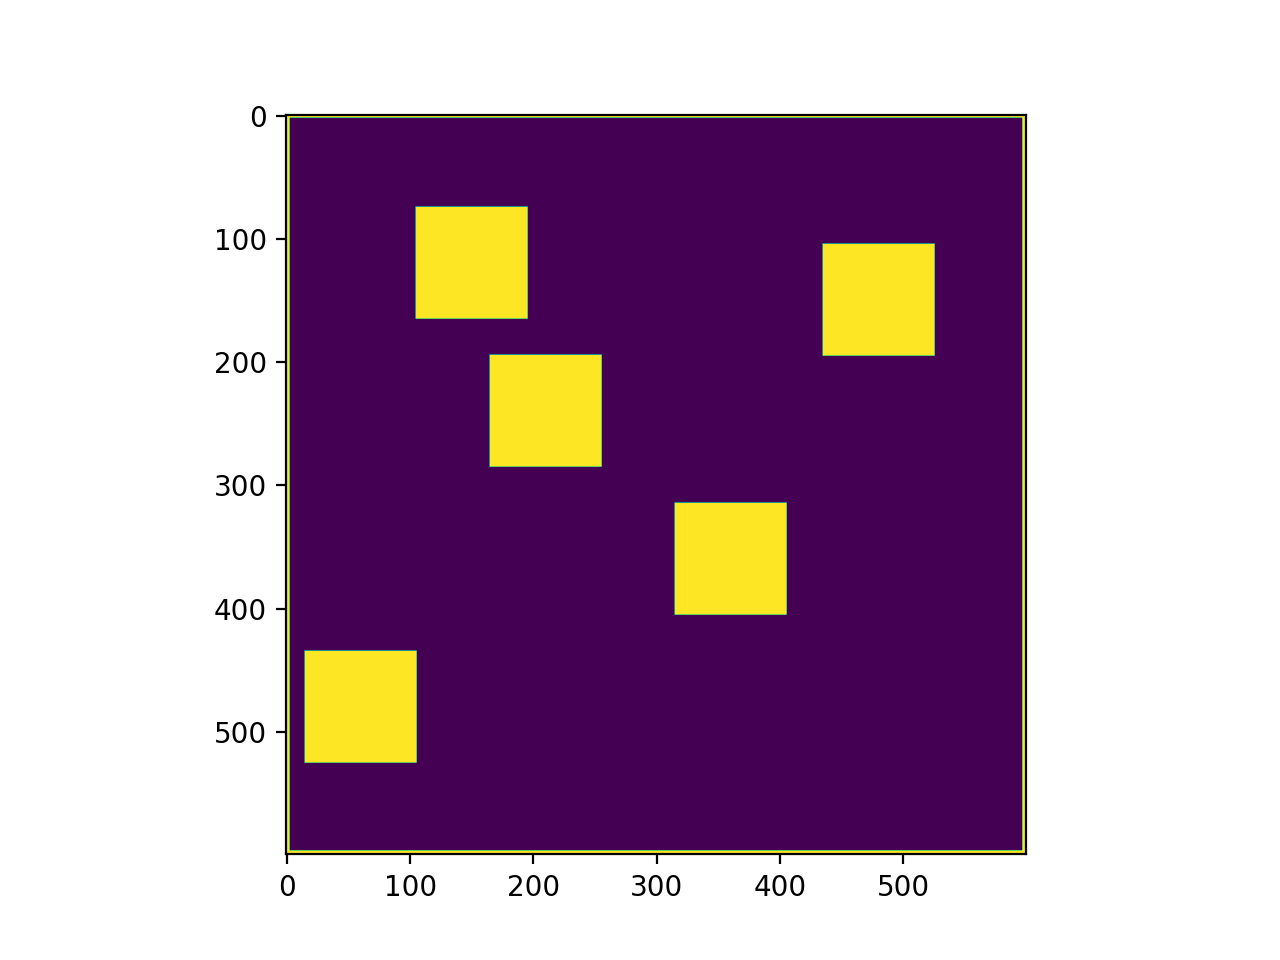

In [10]:
fig2 = plt.figure()
plt.imshow(mapImgB)

In [12]:
def intersectionLL(p1, p2, a1, a2, limit=0.1, epsilon=1e-3):
    '''
    Return intersection point of 2 lines, and parameter from line 1 and line 2 in standard form.
    L = p + k * v where p is position vector, v is direction vector and k is the parameter.
    
    Parameters:
    p1,p2 is column vector [[x],[y]]
    
    epsilon is for checking if error between intersection from 2 ways of calculation is acceptable or not
    if not None is returned
    
    limit is difference in angle in radians. if angle difference is less than limit, None is returned
    '''
    if(abs(a1-a2) < limit):
        return None
    
    v1 = np.array([[math.cos(a1)], [math.sin(a1)]])
    v2 = np.array([[math.cos(a2)], [math.sin(a2)]])
    
    A = np.concatenate([v1,-v2], axis=1)
    b = p2 - p1
    x = np.matmul(np.linalg.inv(A), b)
    
    #Check
    k1 = x[0,0]
    k2 = x[1,0]
    
    int1 = k1*v1 + p1
    int2 = k2*v2 + p2
    
    if(np.linalg.norm(int1-int2) > epsilon):
        return None

    return ((int1 + int2) / 2, k1, k2)

In [13]:
def interpolatePath(v1,v2,r,epsilon=1e-5):
    '''
    Interpolate path from pose of v1 to v2 using line(s) and an arc (radius r).
    Only allow for 1 arc, if more than 1 arc is used, None is returned. 
    This happens when: 
    - Intersection point from v1 lies in front of v2
    - Same angle but not colinear
    - Pose too close to form arc path
    Parameters: 
    v1 = [[x],[y],[angle]]
    v2 = [[x],[y],[angle]]
    r: radius of connecting arc
    '''
    
    pA = v1[:2]
    vA = np.array([[math.cos(v1[2])], [math.sin(v1[2])]])
    
    pB = v2[:2]
    vB = np.array([[math.cos(v2[2])], [math.sin(v2[2])]])
    
    angle = v2[2] - v1[2]
    vAB = pB-pA
    dist = np.linalg.norm(vAB)
    
    r2 = r*r
    
    if(abs(angle) < epsilon):
        # Same Angle
        if(dist < epsilon):
            # Same point
            return (0) # Move 0 forward
        k = np.dot(vAB.T, vA)
        angleDif = math.acos(k / dist)
        if(abs(angleDif) < epsilon):
            # Straight Line
            return (k)
        
    ret = intersectionLL(pA, pB, v1[2,0], v2[2,0])
    if(ret is None):
        #print("Solve failed")
        return None
    pMid, k1, k2 = ret
    
    # Failing Case
    if(k1 < 0 or k2 > 0):
        #print(f"Failing Case: {k1} {k2}")
        return None
    
    vMid = (vB-vA) / 2
    
    
    d = r / math.sin((math.pi - angle)/2)
    pC = pMid + d * vMid / np.linalg.norm(vMid)
    
    vAC = pC - pA
    #kA = math.sqrt(np.sum(np.power(vAC, 2), axis=0) - r2)
    kA = np.dot(vAC.T, vA)
    
    vBC = pC - pB
    #kB = math.sqrt(np.sum(np.power(vBC, 2), axis=0) - r2)
    kB = np.dot(-vBC.T, vB)
    
    return (kA[0,0], pC, angle[0], kB[0,0])

In [14]:
interpolatePath(np.array([[2],[1],[math.pi/4]]), np.array([[5],[2],[math.atan2(-2,3)]]), 0.4)

(2.217662851184148,
 array([[3.85096715],
        [2.28528173]]),
 -1.3734007669450157,
 1.1142989490981727)

In [15]:
def rotation2D(angle):
    #Angle in radians CCW
    cT = math.cos(angle)
    sT = math.sin(angle)
    return np.array([[cT, -sT], [sT, cT]])

In [16]:
def rotation2DAngle(angle):
    #Angle in radians CCW
    cT = math.cos(angle)
    sT = math.sin(angle)
    return np.array([[cT, -sT, 0], [sT, cT, 0], [0, 0, 1]])

In [17]:
def rotationMatrix2d(angles): #Homogeneous
    N = len(angles)
    cT = np.cos(angles)
    sT = np.sin(angles)
    rotM = np.transpose(np.stack([
        [cT, -sT, np.zeros(N)],
        [sT, cT, np.zeros(N)],
        [np.zeros(N), np.zeros(N), np.ones(N)]
    ]), [2,0,1])
    return rotM

In [18]:
def generateStraightMask(robotBounds, dQ):
    '''
    Return pixels [nx2]
    
    Parameter:
    robotBounding: [[minX, minY], [maxX, maxY]] relative to 0,0 (robot center)
    dQ: movement in pixels (with direction)
    '''
    
    minX, minY, maxX, maxY = np.ceil(robotBounds).ravel()
    
    if(dQ > 0):
        x = np.arange(minX, dQ + maxX + 1)
        y = np.arange(minY, maxY + 1)
    else:
        x = np.arange(minX + dQ , maxX + 1)
        y = np.arange(minY, maxY + 1)
    
    X,Y = np.meshgrid(x,y)
    pixels = np.stack([X.ravel(),Y.ravel()], axis=1)
    
    return pixels.astype(np.int32)

In [19]:
np.ceil(100*robotBounds)

array([[-3., -9.],
       [20., 10.]])

In [20]:
generateStraightMask(100*robotBounds, 10)

array([[-3, -9],
       [-2, -9],
       [-1, -9],
       ...,
       [28, 10],
       [29, 10],
       [30, 10]], dtype=int32)

In [21]:
angleRes = 3 * math.pi/180
arcAngle = math.pi/2

In [22]:
angles = np.arange(0, arcAngle+angleRes, angleRes)
angles

array([0.        , 0.05235988, 0.10471976, 0.15707963, 0.20943951,
       0.26179939, 0.31415927, 0.36651914, 0.41887902, 0.4712389 ,
       0.52359878, 0.57595865, 0.62831853, 0.68067841, 0.73303829,
       0.78539816, 0.83775804, 0.89011792, 0.9424778 , 0.99483767,
       1.04719755, 1.09955743, 1.15191731, 1.20427718, 1.25663706,
       1.30899694, 1.36135682, 1.41371669, 1.46607657, 1.51843645,
       1.57079633, 1.6231562 ])

In [23]:
np.stack([np.sin(angles), 1-np.cos(angles)], 1)

array([[0.        , 0.        ],
       [0.05233596, 0.00137047],
       [0.10452846, 0.0054781 ],
       [0.15643447, 0.01231166],
       [0.20791169, 0.0218524 ],
       [0.25881905, 0.03407417],
       [0.30901699, 0.04894348],
       [0.35836795, 0.06641957],
       [0.40673664, 0.08645454],
       [0.4539905 , 0.10899348],
       [0.5       , 0.1339746 ],
       [0.54463904, 0.16132943],
       [0.58778525, 0.19098301],
       [0.62932039, 0.22285404],
       [0.66913061, 0.25685517],
       [0.70710678, 0.29289322],
       [0.74314483, 0.33086939],
       [0.77714596, 0.37067961],
       [0.80901699, 0.41221475],
       [0.83867057, 0.45536096],
       [0.8660254 , 0.5       ],
       [0.89100652, 0.5460095 ],
       [0.91354546, 0.59326336],
       [0.93358043, 0.64163205],
       [0.95105652, 0.69098301],
       [0.96592583, 0.74118095],
       [0.9781476 , 0.79208831],
       [0.98768834, 0.84356553],
       [0.9945219 , 0.89547154],
       [0.99862953, 0.94766404],
       [1.

In [24]:
def generateStraightMovement(dist, scale, robotBounds):
    # Distance in cm
    dQ = math.ceil(dist * scale)
    maskPixels = generateStraightMask(robotBounds, dQ)
    endPose = np.array([[dQ], [0], [0]])
    return maskPixels, endPose

In [25]:
def generateArcMovement(turningRadius, arcAngle, scale, robotBounds, angleResolution=2 * math.pi/180):
    
    rad = math.ceil(abs(turningRadius) * scale)
    
    tempArange = np.arange(2*rad*2*rad)
    empty = np.zeros((2*rad, 2*rad))
    
    
    if(turningRadius < 0):
        startAngle = 90-arcAngle*180/math.pi
        endAngle = 90
        startPoint = np.array([rad, 2*rad])
    else:
        startAngle = 270
        endAngle = startAngle + arcAngle*180/math.pi
        startPoint = np.array([rad, 0])
        
    #temp = cv.ellipse(empty, (rad,rad), (rad,rad), 0, startAngle, endAngle, [255],radiusRes)
    
    #pixelsFlat = tempArange[(temp == 255).ravel()]
    #y,x = np.divmod(pixelsFlat, 2*rad)
    
    #maskPixels = np.stack([x,y], axis=1) - startPoint
    
    if(arcAngle > 0):
        angles = np.arange(0, arcAngle+angleResolution, angleResolution)
    else:
        angles = np.arange(arcAngle, angleResolution, angleResolution)
    poses = np.array([rad * np.sin(angles), turningRadius*scale*(1-np.cos(angles)), angles])
    if(turningRadius < 0):
        poses[2,:] = -1*poses[2,:]
    
    robotMask = generateStraightMask(robotBounds, 1)
    rotM = rotationMatrix2d(poses[2,:])
    
    pathPixels = poses[:2] + np.matmul(rotM[:,:2,:2], np.expand_dims(robotMask.T, 0)).T
    pathPixels = np.round(np.transpose(pathPixels, [2,0,1]).reshape(-1, 2))
    
    pathPixelsShift = pathPixels - np.min(pathPixels, axis=0)
    
    pathPixelsEncode = pathPixelsShift[:,0]*np.max(pathPixelsShift,axis=0)[-1] + pathPixelsShift[:,1]
    uniquePixels, uniqueIndex = np.unique(pathPixelsEncode, return_index=True)

    pathPixelsF = pathPixels[uniqueIndex]
    
    endPose = np.array([[rad * math.sin(arcAngle)], [ turningRadius*scale*(1-math.cos(arcAngle)) ], [(-1 if turningRadius < 0 else 1)*arcAngle]])
    
    #plt.imshow(temp)

    return pathPixelsF.astype(np.int32), endPose

<IPython.core.display.Javascript object>


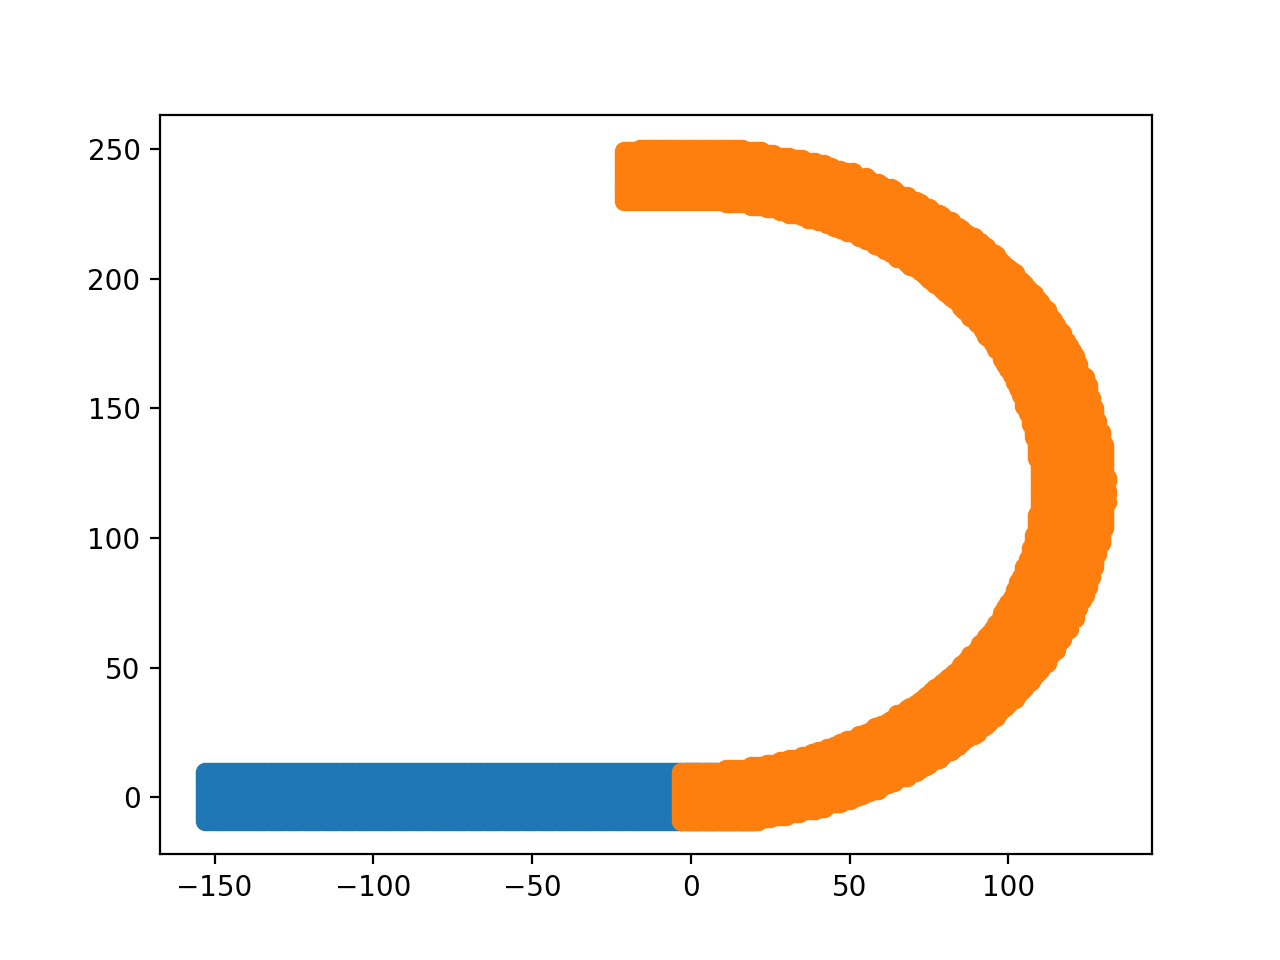

In [26]:
fig3 = plt.figure()

In [27]:
straightPixels, endPoseS = generateStraightMovement(-50, 3, 100*robotBounds)

In [28]:
arcPixels, endPoseA = generateArcMovement(40*3, 180*math.pi/180, 1, 100*robotBounds)

In [29]:
arcPixels.shape

(8575, 2)

In [30]:
plt.scatter(straightPixels[:,0], straightPixels[:,1])

In [31]:
plt.scatter(arcPixels[:,0], arcPixels[:,1])

In [32]:
def getAbsMinAngle(targetAngle, posesAngle):
    return np.min(np.abs(targetAngle + np.array([[2*math.pi,0.0,-2*math.pi]]) - posesAngle), axis=1)

In [33]:
class RRT(object):
    
    def __init__(self, mapImgG: np.ndarray):
        self.reset()
        self.setMap(mapImgG)
        pass
    
    def reset(self):
        # Map
        self.map = None
        self.mapShape = None
        
        
        # Internal Strucutures
        # pose = np.array([[x,y,angle]]) where angle is in radians and x,y in pixels
        # Tree
        self.nodes = [] # List containing poses
        self.costs = []
        self.nodesChild = [] # List containing array of tuple (child index, movementid)
        self.nodesParent = [] # List containing parent index
        self.endIndexes = []
        
        # Goal
        self.start = None
        self.goal = None
        self.closeNodeId = None
        self.path = []
        
        # Status
        self.found = False
        
        # Display
        self.samples = []
        self.connect = []
        
        # Cost
        self.costFunc = None # Cost Function
        
        # Robot bounds
        self.robotBounds = None
        
        pass
    
    def setGoals(self, startPoint, goalPoint):
        self.start = startPoint # np.ndarray [1,3]
        self.goal = goalPoint # np.ndarray [1,3]
        
        self.nodes.append(startPoint)
        self.nodesChild.append([])
        self.nodesParent.append(None)
        self.costs.append(0)
    
    def setMap(self, mapImgG):
        self.map = mapImgG
        self.mapShape = np.array(mapImgG.shape)
        
    def setRobotBounds(self, robotBounds):
        self.robotBounds = robotBounds
        
    def setCostFunction(self, costFunc):
        '''
        Set cost function.
        costFunction(np.ndarray[1,3]: newConf, np.ndarray[n,3]: nodes) -> np.ndarray[n,]: costs
        '''
        self.costFunc = costFunc
    
    def setCommands(self, commands, movements, movementsMask):
        '''
        Set the set of possible commands.
        Parameters:
        commands: list of commands [ commands1, commands2, ... ] ; Commands can be line type or arc type. Line: ('line', d), ('arc', radius, arcAngle)
        movements: list of final pose from each movement [n,3] - used to calculate pose after movement
        movementsMask: list of pixels from each movement len == n (pixels of the path the 'agent' travels through) - used for collision detection
        The movements should be relative to (0,0,0) to correctly add to the current pose
        '''
        self.commands = commands
        self.movements = np.array(movements)
        self.movementsMask = movementsMask
    
    def poseDifference(self, target, poses):
        '''
        Compute pose difference. Return distance and min yaw difference of target against poses.
        Parameters:
        target: np.ndarray[1,3]
        poses: np.ndarray[n,3]
        '''
        
        dist = np.sum(np.power(target[:,:2] - poses[:,:2], 2), axis=1)
        angleDiff = getAbsMinAngle(target[0,2], np.expand_dims(poses[:,2],1))
        
        return np.sqrt(dist), angleDiff
    
    def steer(self, p1, p2):
        '''
        Steer from pose p1 to pose p2. Return path, final pose, commandIndex
        '''
        
        rotM = rotation2D(p1[0,2])
        rotMA = rotation2DAngle(p1[0,2])
        
        # Design Choice: If min cost function cant be perform, return none
        # Alternatives:
        # - Choose min cost that can be performed
        
        # Get min cost action
        endPoses = p1 + np.matmul(np.expand_dims(rotMA,0), self.movements)[:,:,0]
        endPosesCost = self.costFunc(p2, endPoses)
        minCostInd = np.argmin(endPosesCost)
        
        # Check if the action is possible
        movementMask = self.movementsMask[minCostInd]
        pathPixels = self.roundClipToEdge(p1[0,:2] + np.matmul(rotM, movementMask.T).T)
        
        free, pathPixelsF = self.checkFreePixels(pathPixels)
        
        if(free):
            # Path traversable
            return pathPixelsF, endPoses[minCostInd], minCostInd
        else:
            #print(minCostInd)
            return None
        
    def checkFreePixels(self, pathPixels):
        '''
        Return:
        bool: wheather pixels path is free (doesnt collide with obstacles)
        Parameter:
        pathPixels: np.ndarray[n x 2]
        '''
        
        pathPixelsEncode = pathPixels[:,0]*self.mapShape[1] + pathPixels[:,1]
        uniquePixels, uniqueIndex = np.unique(pathPixelsEncode, return_index=True)
        
        pathPixelsF = pathPixels[uniqueIndex]
        
        checkFreePixels = self.map[pathPixelsF[:,1], pathPixelsF[:,0]] == 0
        return np.all(checkFreePixels), pathPixelsF
    
    def roundClipToEdge(self, vertices):
        '''
        Round and clip pixels values to within map boundary
        
        Parameters:
        vertices is (Nx2) array
        '''
        return np.clip(np.round(vertices).astype(np.int32), [0,0], self.mapShape[::-1]-1)
    
    def connectPoses(self, pose1, pose2, rMin, addP1=True, pose1Ind=None, pose1ParentInd=None, pose1CmdInd=None, pose1CmdPath=None, pose1Cost=None):
        if(not addP1 and pose1Ind is None):
            raise IndexError("Pose 1 Index must not be none if addP1 is fFlse.")
        if(addP1 and pose1ParentInd is None):
            raise IndexError("Pose 1 Parent Index must not be none if addP1 is True.")
        if(addP1 and pose1CmdInd is None):
            raise IndexError("Pose 1 Command Index must not be none if addP1 is True.")
        if(addP1 and pose1CmdPath is None):
            raise IndexError("Pose 1 Command Path must not be none if addP1 is True.")
        if(addP1 and pose1Cost is None):
            raise IndexError("Pose 1 Cost must not be none if addP1 is True.")
        
        connectRet = interpolatePath(np.expand_dims(pose1,-1), np.expand_dims(pose2, -1), rMin)
        if(connectRet is not None):

            l1, arcC, difAngle, l2 = connectRet
            difAngle = difAngle
            
            distLimit = math.sqrt(self.mapShape[0]**2 + self.mapShape[1]**2)
            if(l1 > distLimit or l2 > distLimit):
                return None

            m1, p1 = generateStraightMovement(l1, 1, self.robotBounds)

            rotMA1 = rotation2DAngle(pose1[2])
            rotM1 = rotation2D(pose1[2])
            pos1 = pose1 + np.matmul(rotMA1, p1)[:,0]
            pathPixels1 = self.roundClipToEdge(np.expand_dims(pose1[:2],0) + np.matmul(rotM1, m1.T).T)
            free1, ppf1 = self.checkFreePixels(pathPixels1)

            if(not free1):
                return None

            # Free pass 1
            cp = np.cross(np.array([math.cos(pos1[2]), math.sin(pos1[2]), 0]), np.concatenate([arcC[:,0] - pos1[:2],[0]]))
            if(cp[2] < 0):
                r = -rMin
                difAngle = -difAngle
            else:
                r = rMin

            rotMA2 = rotation2DAngle(pos1[2])
            rotM2 = rotation2D(pos1[2])

            m2, p2 = generateArcMovement(r, difAngle, 1, self.robotBounds)
            pos2 = pos1 + np.matmul(rotMA2, p2)[:,0]
            pathPixels2 = self.roundClipToEdge(np.expand_dims(pos1[:2],0) + np.matmul(rotM2, m2.T).T)
            free2, ppf2 = self.checkFreePixels(pathPixels2)
            if(not free2):
                return None
            # Free pass 2
            rotMA3 = rotation2DAngle(pos2[2])
            rotM3 = rotation2D(pos2[2])

            m3, p3 = generateStraightMovement(l2, 1, self.robotBounds)
            pos3 = pos2 + np.matmul(rotMA3, p3)[:,0]
            pathPixels3 = self.roundClipToEdge(np.expand_dims(pos2[:2],0) + np.matmul(rotM3, m3.T).T)
            free3, ppf3 = self.checkFreePixels(pathPixels3)
            if(not free3):
                return None
            # Free Pass 3
            # Reached

            if(addP1):
                nCInd = len(self.nodes)
                p1Ind = nCInd + 1
            else:
                nCInd = pose1Ind
                p1Ind = len(self.nodes)
            p2Ind = p1Ind + 1
            p3Ind = p2Ind + 1

            if(addP1):
                self.nodesChild[pose1ParentInd].append((nCInd, self.commands[pose1CmdInd], pose1CmdPath))
                self.nodes.append(pose1)
                self.nodesChild.append([])
                self.nodesParent.append(pose1ParentInd)
                self.costs.append(pose1Cost)

            self.nodesChild[nCInd].append((p1Ind, ('line', l1), ppf1))
            self.nodes.append(pos1)
            self.nodesChild.append([])
            self.nodesParent.append(nCInd)
            self.costs.append(abs(l1))

            self.nodesChild[p1Ind].append((p2Ind, ('arc', r, difAngle), ppf2))
            self.nodes.append(pos2)
            self.nodesChild.append([])
            self.nodesParent.append(p1Ind)
            self.costs.append(abs(difAngle*rMin))

            self.nodesChild[p2Ind].append((p3Ind, ('line', l2), ppf3))
            self.nodes.append(pos3)
            self.nodesChild.append([])
            self.nodesParent.append(p2Ind)
            self.costs.append(abs(l2))

            self.closeNodeId = p3Ind

            self.connect.append((pos1, ppf1))
            self.connect.append((pos2, ppf2))
            self.connect.append((pos3, ppf3))

            print(f"Connect Point:{pos3} Goal Point:{pose2}")
            print(f"Connect Parameters:{connectRet} Start: {pose1}")

            return True
        
    def getCommandDistance(self, cmdInd):
        # Calculate Distance moved
        steerCmd = self.commands[cmdInd]
        if(steerCmd[0] == 'line'):
            distance = abs(steerCmd[1])
        elif(steerCmd[0] == 'arc'):
            distance = abs(steerCmd[1] * steerCmd[2])
            
        return distance 
    
    def addNode(self, rMin, connectSearchRadius=100, greedyBias=0.05, goalThreshold=(15,10*math.pi/180), sameThreshold=(1,0.2*math.pi/180)):
        '''
        
        rmin: rmin for connect function
        goalThreshold: Max difference for pose to be considered within goal (max dist, max angle) angle in radians
        sameThreshold: Max difference for poses to be considered same nodes
        '''
        
        # Sample Random Configuration
        while True:
            
            if(random.random() < (1-greedyBias)):
                rConf = np.concatenate([self.roundClipToEdge(np.multiply(self.mapShape[::-1], np.random.uniform(size=(2)))), [2*math.pi*np.random.uniform()]])
            else:
                rConf = self.goal
            
            if(self.map[int(rConf[1]), int(rConf[0])] == 0): # Non colliding point
                self.samples.append(rConf) # Add to samples list for visualization
                rConf = np.expand_dims(rConf,0)
                break
        
        # Find nearest neighbour
        nodesVec = np.stack(self.nodes,axis=0)
        costVec = np.stack(self.costs)
        costs = self.costFunc(rConf, nodesVec) + costVec
        minCostInd = np.argmin(costs)
        
        minCostNode = nodesVec[minCostInd]
        
        addedNode = False
        
        steerRet = self.steer(np.expand_dims(minCostNode,0), rConf)
        if(steerRet is None):
            return self.found, addedNode
        
        path, newConf, cmdInd = steerRet
        distance = self.getCommandDistance(cmdInd)
        
        
        '''
        # Check if arrive at rConf
        dRConf = rConf - path
        dRConfMag = np.sqrt(np.sum(np.power(dRConf, 2), axis=1))
        '''
        
        
        '''
        # Check if at goal
        dGoal = self.goal[:2] - path
        dGoalMag = np.sqrt(np.sum(np.power(dGoal, 2), axis=1))
        dGoalMagMask = dGoalMag <= goalThreshold[0]
        if(np.any(dGoalMagMask)):
            # If near goal in position axes
            
            reachGoal = False
            
            # Check angle
            cmd = self.commands[cmdInd]
            if(cmd[0] == 'line'):
                angleDif = getAbsMinAngle(newConf[2], self.goal[2])
                
                if(angleDif <= goalThreshold[1]):
                    # Pass goal
                    reachGoal = True
                    distMove = np.sum(np.power(path - np.expand_dims(minCostNode,0), 2), axis=1)
                    reachPose = np.concatenate([np.min(distMode[dGoalMagMask]), newConf[:,2]],axis=0)
                    #print(reachPose.shape)
            elif(cmd[0] == 'arc'):
                localY = np.expand_dims(rotation2D(math.pi/2 + minCostNode[2])[:,1],0)
                dY = cmd[1] * localY
                rotCenter = minCostNode[:2] + dY
                goalNearPoints = path[dGoalMagMask]
                dGoalNearPoints = goalNearPoints - rotCenter
                #print(localY.shape)
                #print(dGoalNearPoints.shape)
                #print(np.matmul(dGoalNearPoints, -localY.T))
                #print(np.linalg.norm(dGoalNearPoints, axis=1))
                angleDif = np.abs(self.goal[2] - (minCostNode[2] + np.arccos(np.matmul(dGoalNearPoints, -localY.T)[:,0] / (np.linalg.norm(dGoalNearPoints, axis=1)))))
                angleDifMask = angleDif < goalThreshold[1]
                #print(angleDif.shape)
                if(np.any(angleDifMask)):
                    # Pass goal
                    reachGoal = True
                    reachPoseInd = np.argmin(angleDif[angleDifMask])
                    reachPose = np.concatenate([goalNearPoints[angleDifMask][reachPoseInd], [angleDif[angleDifMask][reachPoseInd] + minCostNode[2]]], axis=0)
                    #print(reachPose.shape)
            if(reachGoal):
                self.nodesChild[minCostInd].append((len(self.nodes), self.commands[cmdInd], path)) # Need to change cmdInd and path
                self.closeNodeId = len(self.nodes)
                self.nodes.append(reachPose)
                self.nodesChild.append([])
                self.nodesParent.append(minCostInd)
                
                self.found = True
                return self.found
        '''
        
        # Try connect
        # Check if can connect
        '''
        if(math.sqrt(np.sum(np.power(newConf[:2] - self.goal[:2],2))) <= connectSearchRadius):
            connectRet = interpolatePath(np.expand_dims(newConf,-1), np.expand_dims(self.goal, -1), rMin)
            if(connectRet is not None):

                l1, arcC, difAngle, l2 = connectRet
                difAngle = difAngle

                m1, p1 = generateStraightMovement(l1, 1)

                rotMA1 = rotation2DAngle(newConf[2])
                rotM1 = rotation2D(newConf[2])
                pos1 = newConf + np.matmul(rotMA1, p1)[:,0]
                pathPixels1 = self.roundClipToEdge(np.expand_dims(newConf[:2],0) + np.matmul(rotM1, m1.T).T)
                free1, ppf1 = self.checkFreePixels(pathPixels1)

                if(free1):

                    # Free pass 1
                    cp = np.cross(np.array([math.cos(pos1[2]), math.sin(pos1[2]), 0]), np.concatenate([arcC[:,0] - pos1[:2],[0]]))
                    if(cp[2] < 0):
                        r = -rMin
                        difAngle = -difAngle
                    else:
                        r = rMin

                    rotMA2 = rotation2DAngle(pos1[2])
                    rotM2 = rotation2D(pos1[2])

                    m2, p2 = generateArcMovement(r, difAngle, 1)
                    pos2 = pos1 + np.matmul(rotMA2, p2)[:,0]
                    pathPixels2 = self.roundClipToEdge(np.expand_dims(pos1[:2],0) + np.matmul(rotM2, m2.T).T)
                    free2, ppf2 = self.checkFreePixels(pathPixels2)
                    if(free2):

                        # Free pass 2
                        rotMA3 = rotation2DAngle(pos2[2])
                        rotM3 = rotation2D(pos2[2])

                        m3, p3 = generateStraightMovement(l2, 1)
                        pos3 = pos2 + np.matmul(rotMA3, p3)[:,0]
                        pathPixels3 = self.roundClipToEdge(np.expand_dims(pos2[:2],0) + np.matmul(rotM3, m3.T).T)
                        free3, ppf3 = self.checkFreePixels(pathPixels3)
                        if(free3):

                            # Free Pass 3
                            # Reached

                            self.found = True

                            nCInd = len(self.nodes)
                            p1Ind = nCInd + 1
                            p2Ind = p1Ind + 1
                            p3Ind = p2Ind + 1

                            self.nodesChild[minCostInd].append((nCInd, self.commands[cmdInd], path))
                            self.nodes.append(newConf)
                            self.nodesChild.append([])
                            self.nodesParent.append(minCostInd)

                            self.nodesChild[nCInd].append((p1Ind, ('line', float(l1)), ppf1))
                            self.nodes.append(pos1)
                            self.nodesChild.append([])
                            self.nodesParent.append(nCInd)

                            self.nodesChild[p1Ind].append((p2Ind, ('arc', r, float(difAngle)), ppf2))
                            self.nodes.append(pos2)
                            self.nodesChild.append([])
                            self.nodesParent.append(p1Ind)

                            self.nodesChild[p2Ind].append((p3Ind, ('line', float(l2)), ppf3))
                            self.nodes.append(pos3)
                            self.nodesChild.append([])
                            self.nodesParent.append(p2Ind)

                            self.closeNodeId = p3Ind
                                
                            self.connect.append((pos1, ppf1))
                            self.connect.append((pos2, ppf2))
                            self.connect.append((pos3, ppf3))
                            
                            print(f"Connect Point:{pos3} Goal Point:{self.goal}")
                            print(f"Connect Parameters:{connectRet} Start: {newConf}")
                            
                            return self.found
        '''
        
        # NO auto search for bidirectional
        #if(math.sqrt(np.sum(np.power(newConf[:2] - self.goal[:2],2))) <= connectSearchRadius):
        #    connectRet = self.connectPoses(newConf, self.goal, rMin, pose1ParentInd=minCostInd, pose1CmdInd=cmdInd, pose1CmdPath=path, pose1Cost=distance)     
        #    if(connectRet is not None):
        #        self.found=True
        #        addedNode = True
        #        return self.found, addedNode
            
        # Check if new node or not
        distDif, angleDif = self.poseDifference(np.expand_dims(newConf,0), nodesVec)
        distDifMask = distDif <= sameThreshold[0]
        angleDifMask = angleDif <= sameThreshold[1]
        sameMask = np.logical_and(distDifMask, angleDifMask)
        if(not np.any(sameMask)):
            addedNode = True
            self.nodesChild[minCostInd].append((len(self.nodes), self.commands[cmdInd], path))

            self.nodes.append(newConf)
            self.nodesChild.append([])
            self.nodesParent.append(minCostInd)
            self.costs.append(distance)
        else:
            #print(f"[Same] cmdInd:{cmdInd}\nNewConf:\n{newConf}\nNodesVec:\n{nodesVec}\ndistDif\n{distDif}")
            pass

        return self.found, addedNode
            
            
    def constructPath(self):
        self.path = []
        if(self.found):
            nodeInd = self.closeNodeId
            while(nodeInd is not None):
                  
                parentInd = self.nodesParent[nodeInd]
                  
                if(parentInd is not None):
                    for childInd, cmdInd, childPath in self.nodesChild[parentInd]:
                        if(childInd == nodeInd):
                            self.path.append((self.nodes[childInd], cmdInd, childPath))
                            break
                else:
                    self.path.append((self.nodes[nodeInd], -1, np.array([[]])))
                nodeInd = parentInd
    
    def showState(self, pointerRad = 5, lineWidth = 2, arrowLength=10, path=True, connect=True, sample=True):
        #Return map marked
        img = 255*np.stack([self.map, self.map, self.map], axis=-1)
        
        #return img
        
        #Edges
        for v in self.nodesChild:
            for i,c,p in v:
                img[p[:,1], p[:,0],:] = np.array([0,255,255])
            
        #Nodes
        nodes = self.nodes[:]

        for n in nodes:
            c = (0, 255, 255)
            srcPoint = (int(n[0]),int(n[1]))
            targetPoint = (int(n[0] + arrowLength*math.cos(n[2])), int(n[1] + arrowLength*math.sin(n[2])))
            #print(srcPoint)
            #print(targetPoint)
            img = cv.circle(img, srcPoint, pointerRad, c, thickness=-1)
            img = cv.arrowedLine(img, srcPoint, targetPoint, c, thickness=lineWidth)
            
        
        if(len(self.path) > 0 and path):
            
            c = (0, 0, 255)
            for n,cmdInd,pathPixels in self.path:
                srcPoint = (int(n[0]),int(n[1]))
                targetPoint = (int(n[0] + arrowLength*math.cos(n[2])), int(n[1] + arrowLength*math.sin(n[2])))
                img = cv.circle(img, srcPoint, pointerRad, c, thickness=-1)
                img = cv.arrowedLine(img, srcPoint, targetPoint, c, thickness=lineWidth)
                if(len(pathPixels[0]) != 0):
                    img[pathPixels[:,1], pathPixels[:,0],:] = np.array(list(c))

        
        if(len(self.samples) > 0 and sample):
            img = cv.circle(img, (int(self.samples[-1][0]), int(self.samples[-1][1])), pointerRad, (255, 255 ,0), thickness=-1)
        
        
        # Plot connecting point 
        if(connect):
            for n, p in self.connect:
                srcPoint = (int(n[0]),int(n[1]))
                targetPoint = (int(n[0] + arrowLength*math.cos(n[2])), int(n[1] + arrowLength*math.sin(n[2])))
                c = (255,127,64)
                img = cv.circle(img, srcPoint, pointerRad, c, thickness=-1)
                img = cv.arrowedLine(img, srcPoint, targetPoint, c, thickness=lineWidth)
                if(len(p[0]) != 0):
                    img[p[:,1], p[:,0],:] = np.array(list(c))
        
        # Plot start pose
        n = self.start
        srcPoint = (int(n[0]),int(n[1]))
        targetPoint = (int(n[0] + arrowLength*math.cos(n[2])), int(n[1] + arrowLength*math.sin(n[2])))
        c = (0,255,0)
        img = cv.circle(img, srcPoint, pointerRad, c, thickness=-1)
        img = cv.arrowedLine(img, srcPoint, targetPoint, c, thickness=lineWidth)
        
        # Plot goal pose
        n = self.goal
        srcPoint = (int(n[0]),int(n[1]))
        targetPoint = (int(n[0] + arrowLength*math.cos(n[2])), int(n[1] + arrowLength*math.sin(n[2])))
        c = (255,0,0)
        img = cv.circle(img, srcPoint, pointerRad, c, thickness=-1)
        img = cv.arrowedLine(img, srcPoint, targetPoint, c, thickness=lineWidth)
        
        
        
        return img

In [34]:
def forwardVector(angles):
    return np.transpose(np.array([[np.cos(angles)], [np.sin(angles)]]), [2,0,1])

In [35]:
def plotPose(poses, color=(1,1,0,1)):
    # poses = [[[x],[y],[angle]], [[x],[y],[angle]]]
    
    plt.scatter(poses[:,0,0], poses[:,1,0], color=color)
    
    forVec = forwardVector(poses[:,2,0])
    #print(forVec.shape)
    
    plt.quiver(poses[:,0,0], poses[:,1,0], forVec[:,0,0], forVec[:,1,0], color=[color])

In [36]:
def colorF1(index):
    r = random.randint(0,2 ** 24)
    return (((r & 0xFF0000) >> 16) / 255, ((r & 0x00FF00) >> 8) / 255, (r & 0x0000FF) / 255,1)

In [37]:
def plotMovements(startingPose, movements, movementsMask, colorFunc, showPath=True):
    
    fig = plt.figure()
    
    rotM = rotation2D(startingPose[0,2])
    rotMA = rotation2DAngle(startingPose[0,2])
    print(startingPose.shape)
    print(rotMA)
    mvNp = np.array(movements)
    print(rotMA.shape)
    print(mvNp.shape)
    print(np.matmul(np.expand_dims(rotMA,0), mvNp)[:,:,0].shape)
    endPoses = startingPose + np.matmul(np.expand_dims(rotMA,0), mvNp)[:,:,0]
    print(endPoses)
    print(endPoses.shape)
    
    plotPose(np.expand_dims(startingPose,-1))
    
    for i,mm in enumerate(movementsMask):
        c = colorFunc(i)
        endPosePath = startingPose[0,:2] + np.matmul(rotM, mm.T).T
        print((np.expand_dims(endPoses[i], -1)).shape)
        plotPose(np.expand_dims(np.array([endPoses[i]]), -1), color=c)
        if(showPath):
            plt.scatter(endPosePath[:,0], endPosePath[:,1], color=c)
    
    labels = ["Origin"]
    plt.legend(labels)
    plt.axis('equal')
        
    return fig

In [38]:
def distanceCost(newConf, nodes, A=1.0):
    '''
    Distance cost function. A is weight for angle difference
    costFunction(np.ndarray[1,3]: newConf, np.ndarray[n,3]: nodes) -> np.ndarray[n,]: costs
    '''
    
    distCost = np.sum(np.power(newConf[:,:2] - nodes[:,:2],2),axis=1)
    angDif = newConf[:,2] - nodes[:,2]
    angCost = np.min(np.concatenate([np.power(angDif,2), np.power(angDif + math.pi,2), np.power(angDif - math.pi,2)], axis=0),axis=0)
    return distCost + A * angCost

In [39]:
rMin = 0.4

In [40]:
# A is tune to give weighting of 1 pixel distance to 1 radians

# A = (1*mapScale)/(1 * math.pi/180) # 1 cm weight = 1 radians
# A = rMin # yaw change * radians = turning distance <- this roughly converts angles to turning distance 
# A = 0.1
# A = 40 ** 2 - 40
A = 0

In [41]:
distCost = functools.partial(distanceCost, A=A)

In [42]:
rrt1 = RRT(mapImgB)

In [43]:
rrt1.setGoals(np.array([50,50, math.pi/2]), np.array([350,250, math.pi/2]))
#rrt1.setGoals(np.array([50,50, math.pi/2]), np.array([470,350, -math.pi]))
#rrt1.setGoals(np.array([30,30, math.pi/2]), np.array([240,240, -math.pi]))

In [44]:
rrt1.setCostFunction(distCost)

In [45]:
movements = []
movementsMask = []

lDist = 20

commands = [
    ('line', lDist),
    ('line', -lDist)
]

rads = [40, 80, 120]
for r in rads:
    commands.append(('arc', r, lDist/r))
    commands.append(('arc', r, -lDist/r))
    commands.append(('arc', -r, lDist/r))
    commands.append(('arc', -r, -lDist/r))

for c in commands:
    if(c[0] == 'line'):
        m, p = generateStraightMovement(c[1], mapScale, mapScale*100*robotBounds)
    elif(c[0] == 'arc'):
        m, p = generateArcMovement(c[1], c[2], mapScale, mapScale*100*robotBounds)
        
    movements.append(p)
    movementsMask.append(m)

In [46]:
commands

[('line', 20),
 ('line', -20),
 ('arc', 40, 0.5),
 ('arc', 40, -0.5),
 ('arc', -40, 0.5),
 ('arc', -40, -0.5),
 ('arc', 80, 0.25),
 ('arc', 80, -0.25),
 ('arc', -80, 0.25),
 ('arc', -80, -0.25),
 ('arc', 120, 0.16666666666666666),
 ('arc', 120, -0.16666666666666666),
 ('arc', -120, 0.16666666666666666),
 ('arc', -120, -0.16666666666666666)]

In [47]:
movements

[array([[60],
        [ 0],
        [ 0]]),
 array([[-60],
        [  0],
        [  0]]),
 array([[57.53106463],
        [14.69009257],
        [ 0.5       ]]),
 array([[-57.53106463],
        [ 14.69009257],
        [ -0.5       ]]),
 array([[ 57.53106463],
        [-14.69009257],
        [ -0.5       ]]),
 array([[-57.53106463],
        [-14.69009257],
        [  0.5       ]]),
 array([[59.37695022],
        [ 7.46101879],
        [ 0.25      ]]),
 array([[-59.37695022],
        [  7.46101879],
        [ -0.25      ]]),
 array([[59.37695022],
        [-7.46101879],
        [-0.25      ]]),
 array([[-59.37695022],
        [ -7.46101879],
        [  0.25      ]]),
 array([[59.72260777],
        [ 4.98843664],
        [ 0.16666667]]),
 array([[-59.72260777],
        [  4.98843664],
        [ -0.16666667]]),
 array([[59.72260777],
        [-4.98843664],
        [-0.16666667]]),
 array([[-59.72260777],
        [ -4.98843664],
        [  0.16666667]])]

<IPython.core.display.Javascript object>


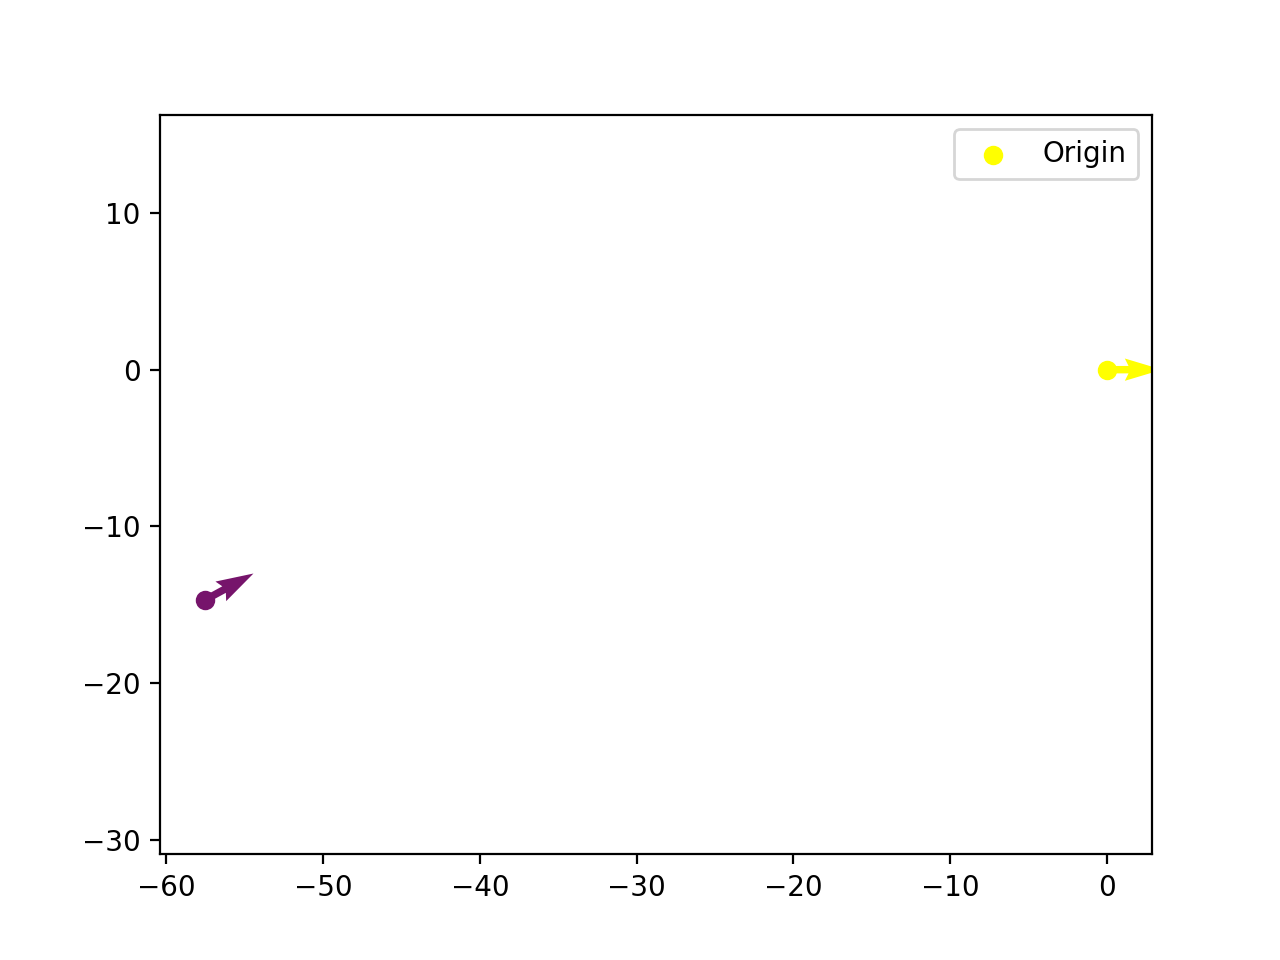

(1, 3)
[[ 1. -0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
(3, 3)
(1, 3, 1)
(1, 3)
[[-57.53106463 -14.69009257   0.5       ]]
(1, 3)
(3, 1)


In [48]:
fig3 = plotMovements(np.array([[0,0,0]]), movements[5:6], movementsMask[5:6], colorF1, showPath=False)

In [49]:
rrt1.setCommands(commands, movements, movementsMask)

In [50]:
rrt1.setRobotBounds(mapScale*100*robotBounds)

In [51]:
rrt1.addNode(40*mapScale)

(False, False)

In [52]:
for i in range(1000):
    found = rrt1.addNode(40*mapScale, connectSearchRadius=300)
    if(found[0]):
        break
        pass

In [53]:
found

(False, False)

In [54]:
rrt1.constructPath()

In [55]:
len(rrt1.path)

0

In [56]:
rrt1.path

[]

In [57]:
rrt1.nodes

[array([50.        , 50.        ,  1.57079633]),
 array([ 57.46101879, 109.37695022,   1.32079633]),
 array([ 57.46101879, 168.75390044,   1.82079633]),
 array([ 57.46101879, 228.13085066,   1.32079633]),
 array([ 85.92784513, 280.23902676,   0.82079633]),
 array([120.94233145, 328.7701999 ,   1.07079633]),
 array([161.41596218, 372.21565344,   0.57079633]),
 array([201.8895929 , 415.66110698,   1.07079633]),
 array([2.17763775e+02, 3.90938534e+02, 7.07963268e-02]),
 array([ 35.96386435, 248.15752364,   0.32079633]),
 array([1.05068150e+02, 3.53492773e+02, 7.07963268e-02]),
 array([242.36322362, 459.10656053,   0.57079633]),
 array([4.63677111e+01, 3.41850285e+02, 3.20796327e-01]),
 array([1.86015411e+02, 4.40383680e+02, 7.07963268e-02]),
 array([2.96358410e+02, 4.84909833e+02, 3.20796327e-01]),
 array([346.32239083, 516.99133594,   0.82079633]),
 array([ 1.05595921e+02,  3.46050444e+02, -1.79203673e-01]),
 array([3.96286372e+02, 5.49072839e+02, 3.20796327e-01]),
 array([ 4.55514582e+0

In [58]:
len(rrt1.nodes)

98

In [59]:
rrt1.nodesChild

[[(1,
   ('arc', -80, 0.25),
   array([[ 21,  41],
          [ 21,  42],
          [ 21,  43],
          ...,
          [102, 167],
          [103, 166],
          [103, 167]]))],
 [(2,
   ('arc', 40, 0.5),
   array([[ 12, 222],
          [ 13, 219],
          [ 13, 220],
          ...,
          [ 99, 166],
          [ 99, 167],
          [100, 162]])),
  (26,
   ('arc', -40, -0.5),
   array([[ 14,  99],
          [ 14, 101],
          [ 14, 102],
          ...,
          [101, 161],
          [101, 162],
          [101, 163]])),
  (68,
   ('arc', -120, -0.16666666666666666),
   array([[ 18,  44],
          [ 18,  45],
          [ 18,  47],
          ...,
          [100, 162],
          [100, 163],
          [100, 164]]))],
 [(3,
   ('arc', -40, 0.5),
   array([[ 14, 221],
          [ 15, 217],
          [ 15, 218],
          ...,
          [101, 281],
          [101, 282],
          [102, 282]]))],
 [(4,
   ('arc', -40, 0.5),
   array([[ 27, 227],
          [ 27, 228],
          [ 28

In [60]:
state = rrt1.showState(arrowLength=30, path=True)

<IPython.core.display.Javascript object>


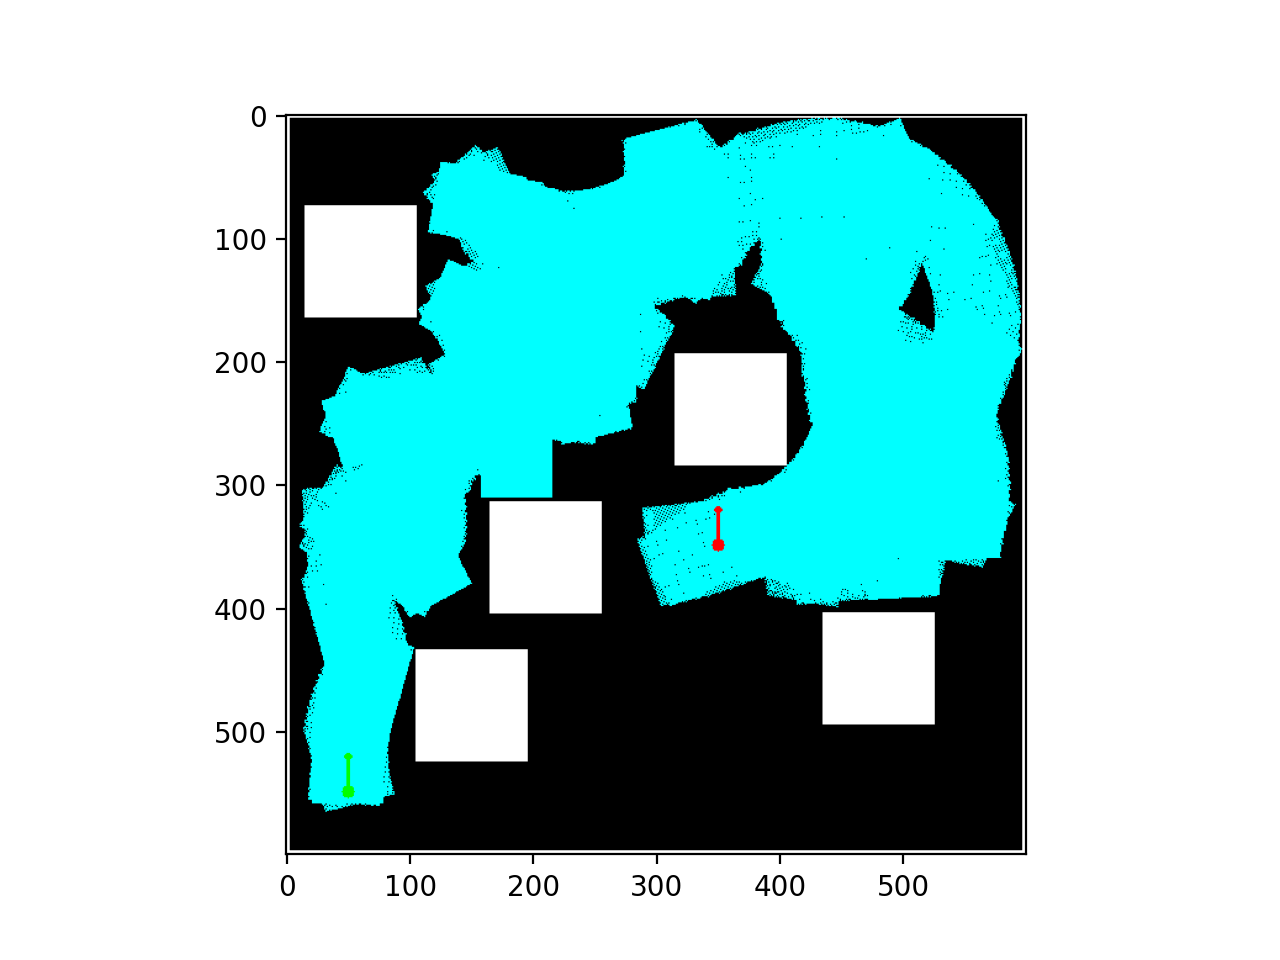

In [61]:
fig4 = plt.figure()
plt.imshow(state[::-1])

In [62]:
def RRTBiDirSearch(imgMap, startPose, endPose, costFunc, cmdSet, movementSet, movementMasks, rMin, scale, robotBounds, iterations=10000):
    treeA = RRT(imgMap)
    treeA.setGoals(startPose, endPose)
    treeA.setCommands(cmdSet, movementSet, movementMasks)
    treeA.setCostFunction(costFunc)
    treeA.setRobotBounds(robotBounds)
    
    treeB = RRT(imgMap)
    treeB.setGoals(endPose, startPose)
    treeB.setCommands(cmdSet, movementSet, movementMasks)
    treeB.setCostFunction(costFunc)
    treeB.setRobotBounds(robotBounds)
    
    tree1 = treeA
    tree2 = treeB
    
    for i in range(iterations):
        f, newNode = tree1.addNode(rMin)
        if(newNode):
            rConf = tree1.nodes[-1]
            #print(rConf)
            nodesVec = np.stack(tree2.nodes,axis=0)
            costs = tree2.costFunc(np.expand_dims(rConf,0), nodesVec)
            minCostInd = np.argmin(costs)

            minCostNode = nodesVec[minCostInd]
            connectRet = tree2.connectPoses(minCostNode, rConf, rMin, addP1=False, pose1Ind=minCostInd)
            if(connectRet is not None):
                
                tree1.found = True
                tree2.found = True
                
                tree1.closeNodeId = len(tree1.nodes) - 1
                tree2.closeNodeId = len(tree2.nodes) - 1
                
                tree1.constructPath()
                tree2.constructPath()
                
                path = []
                v=0.2
                for node, cmd, pixels in treeA.path[::-1]:
                    if(cmd != -1):
                        if(cmd[0] == 'line'):
                            path.append((cmd[0], cmd[1]/100, v if(cmd[1] > 0) else -v))
                        elif(cmd[0] == 'arc'):
                            r = cmd[1]
                            dYaw = cmd[2]
                            if(r < 0):
                                dYaw *= -1
                            path.append((cmd[0], dYaw, r/100, v if dYaw*r > 0 else -v))
                        if(cmd[0] == 'lineC'):
                            path.append(('line', cmd[1]/(scale*100), v if(cmd[1] > 0) else -v))
                        elif(cmd[0] == 'arcC'):
                            r = cmd[1]
                            dYaw = cmd[2]
                            if(r < 0):
                                dYaw *= -1
                            path.append(('arc', dYaw, r/(scale*100), v if dYaw*r > 0 else -v))

                for node, cmd, pixels in treeB.path:
                    if(cmd != -1):
                        if(cmd[0] == 'line'):
                            path.append((cmd[0], -cmd[1]/100, v if(cmd[1] <0) else -v))
                        elif(cmd[0] == 'arc'):
                            r = cmd[1]
                            dYaw = cmd[2]
                            if(r < 0):
                                dYaw *= -1
                            path.append((cmd[0], -dYaw, r/100, v if dYaw*r < 0 else -v))
                        elif(cmd[0] == 'lineC'):
                            path.append(('line', -cmd[1]/(100*scale), v if(cmd[1] <0) else -v))
                        elif(cmd[0] == 'arcC'):
                            r = cmd[1]
                            dYaw = cmd[2]
                            if(r < 0):
                                dYaw *= -1
                            path.append(('arc', -dYaw, r/(100*scale), v if dYaw*r < 0 else -v))

                simplePath = []
                cmdType=""
                dist = 0.0
                r = 0.0
                dYaw = 0.0
                v = 0

                print(path)

                path.append(('Empty'))
                for cmd in path:
                    if(cmd[0] != cmdType):
                        if(cmdType == 'line'):
                            simplePath.append(('line', dist, v))
                        elif(cmdType == 'arc'):
                            simplePath.append(('arc', dYaw, r, v))
                        cmdType = cmd[0]
                        if(cmdType == 'line'):
                            dist = cmd[1]
                            v = cmd[2]
                        elif(cmdType == 'arc'):
                            dYaw = cmd[1]
                            r = cmd[2]
                            v = cmd[3]
                    else:
                        if(cmdType == 'line'):
                            dist += cmd[1]
                        elif(cmdType == 'arc'):
                            if(cmd[2] != r):
                                simplePath.append(('arc', dYaw, r, v))
                                dYaw = cmd[1]
                                r = cmd[2]
                                v = cmd[3]
                            else:
                                dYaw += cmd[1]

                print(simplePath)
                
                fig = plt.figure()
                
                stateSum = tree1.showState(arrowLength=30, path=True) + tree2.showState(arrowLength=30, path=True)
                plt.imshow(stateSum[::-1])
                
                break
                
        tree1, tree2 = tree2, tree1
        
    print(i)
    
    

Connect Point:[247.05994632 435.79011109  -1.67920367] Goal Point:[246.58476778 436.80816178  -1.67920367]
Connect Parameters:(-62.65933377588067, array([[119.64502135],
       [379.55448735]]), -1.0833333333333333, -70.65183975823555) Start: [238.85318514 443.70747477  -0.59587034]
[('line', 0.2, 0.2), ('arc', -0.5, -0.4, 0.2), ('arc', 0.5, 0.4, 0.2), ('arc', -0.16666666666666666, 1.2, -0.2), ('arc', -0.5, -0.4, 0.2), ('arc', 0.5, 0.4, 0.2), ('arc', -0.5, -0.4, 0.2), ('arc', -0.5, -0.4, 0.2), ('arc', 0.5, 0.4, 0.2), ('arc', 0.5, 0.4, 0.2), ('arc', -0.5, -0.4, 0.2), ('arc', -0.5, 0.4, -0.2), ('arc', -0.5, 0.4, -0.2), ('arc', -0.5, -0.4, 0.2), ('line', -0.6265933377588067, -0.2), ('arc', -1.0833333333333333, -1.2, 0.2), ('line', -0.7065183975823556, -0.2), ('arc', 0.5, 0.4, 0.2), ('line', 0.2, 0.2), ('line', 0.2, 0.2), ('arc', -0.5, -0.4, 0.2), ('arc', 0.5, 0.4, 0.2), ('arc', 0.5, 0.4, 0.2), ('arc', 0.5, -0.4, -0.2), ('arc', 0.5, -0.4, -0.2), ('arc', 0.5, 0.4, 0.2), ('line', -0.2, -0.2)

<IPython.core.display.Javascript object>


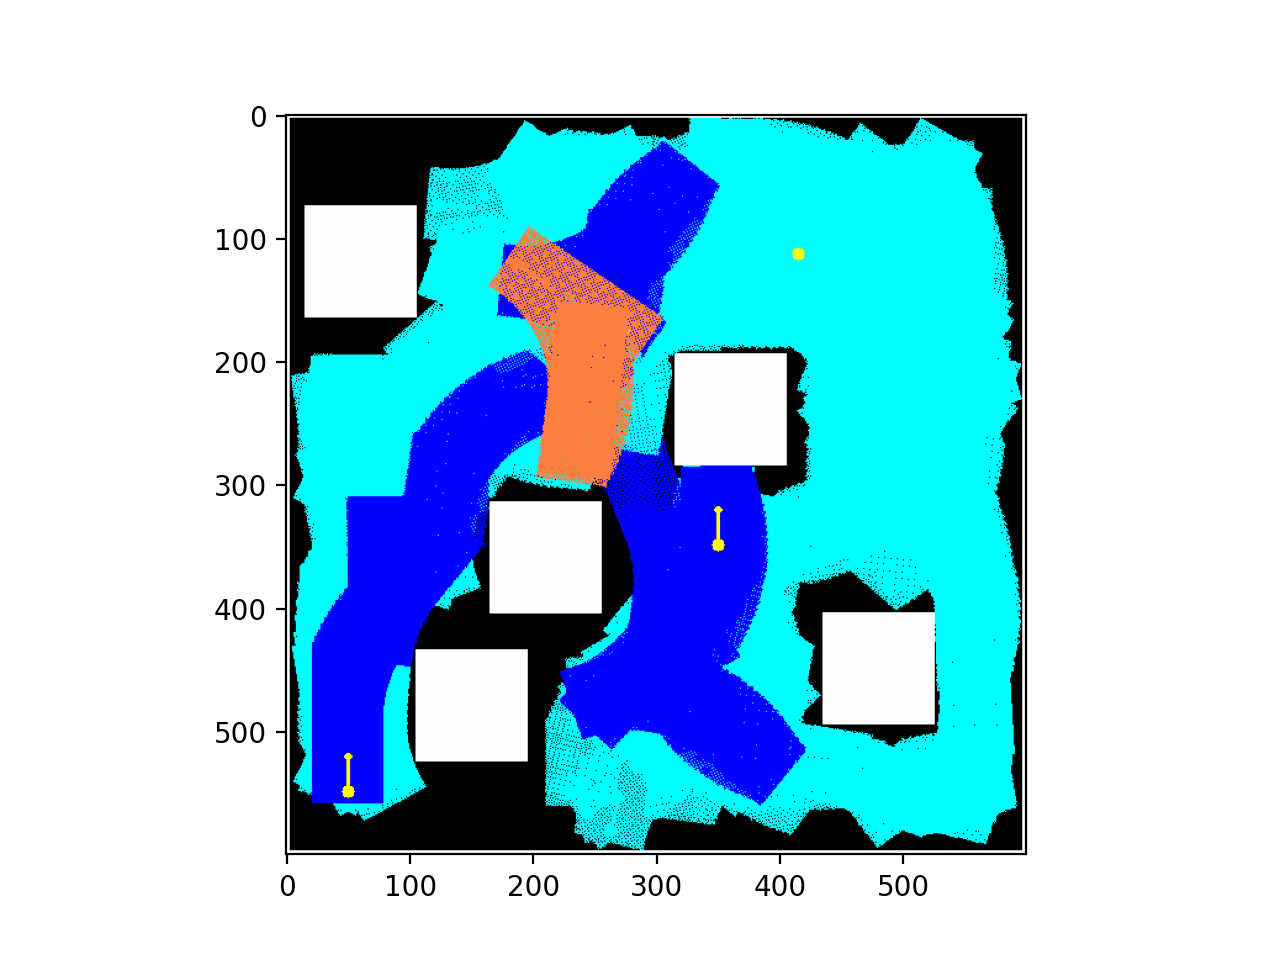

5597


In [63]:
RRTBiDirSearch(mapImgB, np.array([50,50, math.pi/2]), np.array([350,250, math.pi/2]), distCost, commands, movements, movementsMask, 40*mapScale, mapScale, mapScale*100*robotBounds)